In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cactas as C
import os
import mahotas as mh
import nibabel as nib
import nrrd
import skimage.morphology
import cv2
from skimage.filters import threshold_otsu

2024-05-15 18:50:13.491946: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-15 18:50:15.305000: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 18:50:15.306163: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-15 18:50:15.645146: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-15 18:50:15.647682: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 3

True

In [4]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'
CAPATH='/raid/mpsych/CACTAS/DATA/CA24'

In [5]:
images, labels = C.Helper.load_data(DATAPATH)

In [6]:
masks = C.Helper.load_seg_data(CAPATH)

In [7]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.split_patients_masks(images, labels, masks)

In [8]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.normalization2(DATAPATH, CAPATH, X_train, y_train, m_train, X_test, y_test, m_test)

In [9]:
slice_to_patient_mapping, last_key = C.Helper.map_and_key_fulldata(y_train)

In [10]:
last_key

10370

In [11]:
X_train, y_train, X_test, y_test = C.Helper.extract_slices(X_train, y_train, X_test, y_test)

(13140, 512, 512, 1) (13140, 512, 512, 1) (3626, 512, 512, 1) (3626, 512, 512, 1)


In [12]:
m_train, m_test = C.Helper.extract_masks_slices(m_train, m_test)

(13140, 512, 512, 1) (3626, 512, 512, 1)


In [13]:
train_masks=[]
for i in range(len(m_train)):
    binary = (m_train[i] > 0).astype(np.uint8)
    train_masks.append(binary)

In [14]:
train_images=[]
for i in range(len(X_train)):
    train_image = X_train[i] * train_masks[i]
    train_images.append(train_image)
train_images_array = np.array(train_images)

In [15]:
train_images_array = train_images_array.astype(np.float32)

In [16]:
train_images_array = train_images_array.reshape(train_images_array.shape[0], train_images_array.shape[1],train_images_array.shape[2], 1)

In [17]:
test_masks=[]
for i in range(len(m_test)):
    binary = (m_test[i] > 0).astype(np.uint8)
    test_masks.append(binary)

In [18]:
test_images=[]
for i in range(len(X_test)):
    test_image = X_test[i] * test_masks[i]
    test_images.append(test_image)
test_images_array = np.array(test_images)

In [19]:
test_images_array = test_images_array.astype(np.float32)

In [20]:
test_images_array = test_images_array.reshape(test_images_array.shape[0], test_images_array.shape[1],test_images_array.shape[2], 1)

In [21]:
X_train_set = train_images_array[:last_key]
y_train_set = y_train[:last_key]
X_val = train_images_array[last_key:]
y_val = y_train[last_key:]

In [22]:
model = C.Helper.create_unet(X_train_set[0].shape)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


2024-05-15 18:53:37.886588: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-15 18:53:37.889132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-15 18:53:37.898930: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0, 1
2024-05-15 18:53:37.902030: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-15 18:53:37.904513: I tensorflow/core

In [23]:
model, history = C.Helper.train_unet(X_train_set, y_train_set, X_val, y_val, model, epochs=200)

2024-05-15 18:53:42.401174: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-05-15 18:53:42.422765: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245740000 Hz


Epoch 1/200


2024-05-15 18:53:44.061957: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-15 18:53:44.858256: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-05-15 18:53:45.879254: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-05-15 18:53:45.879278: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-05-15 18:53:45.879634: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-15 18:53:45.965540: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-15 18:53:46.983392: I tensorflow/stream_exec

648/648 [==============================] - 324s 479ms/step - loss: 0.0924 - iou: 4.7277e-05 - iou_thresholded: 0.2916 - val_loss: 0.0034 - val_iou: 1.0072e-04 - val_iou_thresholded: 0.8695
Epoch 2/200
648/648 [==============================] - 293s 450ms/step - loss: 0.0016 - iou: 2.9942e-04 - iou_thresholded: 0.4418 - val_loss: 9.6398e-04 - val_iou: 2.9811e-04 - val_iou_thresholded: 0.9053
Epoch 3/200
648/648 [==============================] - 291s 449ms/step - loss: 5.7887e-04 - iou: 8.5178e-04 - iou_thresholded: 0.3753 - val_loss: 3.4133e-04 - val_iou: 8.8433e-04 - val_iou_thresholded: 0.8893
Epoch 4/200
648/648 [==============================] - 291s 449ms/step - loss: 3.1469e-04 - iou: 0.0020 - iou_thresholded: 0.4041 - val_loss: 2.0381e-04 - val_iou: 0.0023 - val_iou_thresholded: 0.8497
Epoch 5/200
648/648 [==============================] - 291s 449ms/step - loss: 2.0970e-04 - iou: 0.0039 - iou_thresholded: 0.3918 - val_loss: 1.6241e-04 - val_iou: 0.0021 - val_iou_thresholded: 0.

648/648 [==============================] - 291s 449ms/step - loss: 1.6611e-05 - iou: 0.2944 - iou_thresholded: 0.6584 - val_loss: 1.4356e-05 - val_iou: 0.5792 - val_iou_thresholded: 0.8803
Epoch 42/200
648/648 [==============================] - 291s 449ms/step - loss: 1.6211e-05 - iou: 0.3249 - iou_thresholded: 0.6949 - val_loss: 1.2727e-05 - val_iou: 0.6043 - val_iou_thresholded: 0.8507
Epoch 43/200
648/648 [==============================] - 291s 449ms/step - loss: 1.7320e-05 - iou: 0.2994 - iou_thresholded: 0.6867 - val_loss: 1.3035e-05 - val_iou: 0.5359 - val_iou_thresholded: 0.8919
Epoch 44/200
648/648 [==============================] - 291s 449ms/step - loss: 1.6892e-05 - iou: 0.3016 - iou_thresholded: 0.6648 - val_loss: 1.3515e-05 - val_iou: 0.5488 - val_iou_thresholded: 0.8743
Epoch 45/200
648/648 [==============================] - 291s 449ms/step - loss: 1.5824e-05 - iou: 0.3161 - iou_thresholded: 0.6798 - val_loss: 1.4131e-05 - val_iou: 0.5387 - val_iou_thresholded: 0.8531
Epo

Epoch 82/200
648/648 [==============================] - 291s 449ms/step - loss: 8.3550e-06 - iou: 0.5510 - iou_thresholded: 0.8263 - val_loss: 1.7001e-05 - val_iou: 0.5075 - val_iou_thresholded: 0.8804
Epoch 83/200
648/648 [==============================] - 291s 449ms/step - loss: 8.9600e-06 - iou: 0.5178 - iou_thresholded: 0.8152 - val_loss: 1.6143e-05 - val_iou: 0.6369 - val_iou_thresholded: 0.8413
Epoch 84/200
648/648 [==============================] - 291s 450ms/step - loss: 7.5907e-06 - iou: 0.5460 - iou_thresholded: 0.8276 - val_loss: 1.6319e-05 - val_iou: 0.7169 - val_iou_thresholded: 0.8760
Epoch 85/200
648/648 [==============================] - 292s 451ms/step - loss: 7.9290e-06 - iou: 0.5610 - iou_thresholded: 0.8288 - val_loss: 1.5678e-05 - val_iou: 0.4641 - val_iou_thresholded: 0.8616
Epoch 86/200
648/648 [==============================] - 292s 451ms/step - loss: 9.6842e-06 - iou: 0.4974 - iou_thresholded: 0.7893 - val_loss: 1.4655e-05 - val_iou: 0.6002 - val_iou_thresholde

648/648 [==============================] - 291s 449ms/step - loss: 5.0484e-06 - iou: 0.6892 - iou_thresholded: 0.8761 - val_loss: 1.9379e-05 - val_iou: 0.7385 - val_iou_thresholded: 0.8743
Epoch 123/200
648/648 [==============================] - 291s 449ms/step - loss: 5.5118e-06 - iou: 0.6867 - iou_thresholded: 0.8827 - val_loss: 2.0409e-05 - val_iou: 0.7809 - val_iou_thresholded: 0.8778
Epoch 124/200
648/648 [==============================] - 291s 449ms/step - loss: 5.7214e-06 - iou: 0.7151 - iou_thresholded: 0.8894 - val_loss: 2.0933e-05 - val_iou: 0.6805 - val_iou_thresholded: 0.8868
Epoch 125/200
648/648 [==============================] - 291s 450ms/step - loss: 5.7306e-06 - iou: 0.6802 - iou_thresholded: 0.8824 - val_loss: 2.2433e-05 - val_iou: 0.7616 - val_iou_thresholded: 0.8946
Epoch 126/200
648/648 [==============================] - 291s 449ms/step - loss: 4.6448e-06 - iou: 0.6948 - iou_thresholded: 0.8866 - val_loss: 2.1366e-05 - val_iou: 0.6328 - val_iou_thresholded: 0.8743

648/648 [==============================] - 291s 449ms/step - loss: 4.2339e-06 - iou: 0.7540 - iou_thresholded: 0.9164 - val_loss: 2.4504e-05 - val_iou: 0.4485 - val_iou_thresholded: 0.8754
Epoch 163/200
648/648 [==============================] - 291s 450ms/step - loss: 3.8044e-06 - iou: 0.7386 - iou_thresholded: 0.9212 - val_loss: 2.5621e-05 - val_iou: 0.6381 - val_iou_thresholded: 0.8834
Epoch 164/200
648/648 [==============================] - 291s 449ms/step - loss: 3.9915e-06 - iou: 0.7561 - iou_thresholded: 0.9218 - val_loss: 2.4373e-05 - val_iou: 0.6822 - val_iou_thresholded: 0.8823
Epoch 165/200
648/648 [==============================] - 291s 450ms/step - loss: 4.2855e-06 - iou: 0.7326 - iou_thresholded: 0.9198 - val_loss: 2.7100e-05 - val_iou: 0.7332 - val_iou_thresholded: 0.8824
Epoch 166/200
648/648 [==============================] - 291s 449ms/step - loss: 4.7809e-06 - iou: 0.7104 - iou_thresholded: 0.9152 - val_loss: 2.5239e-05 - val_iou: 0.5549 - val_iou_thresholded: 0.8700

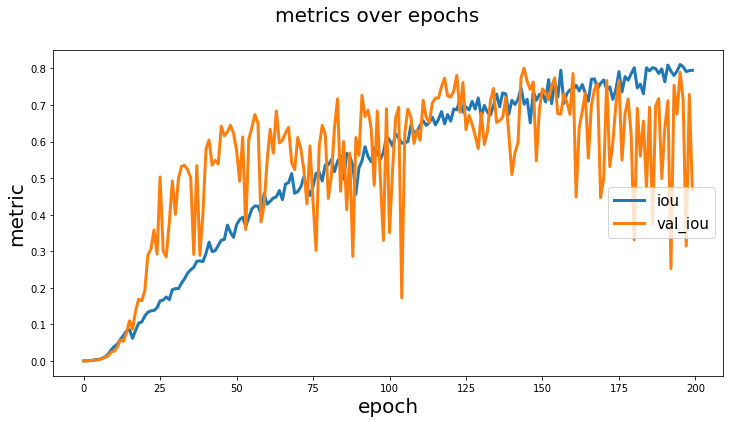

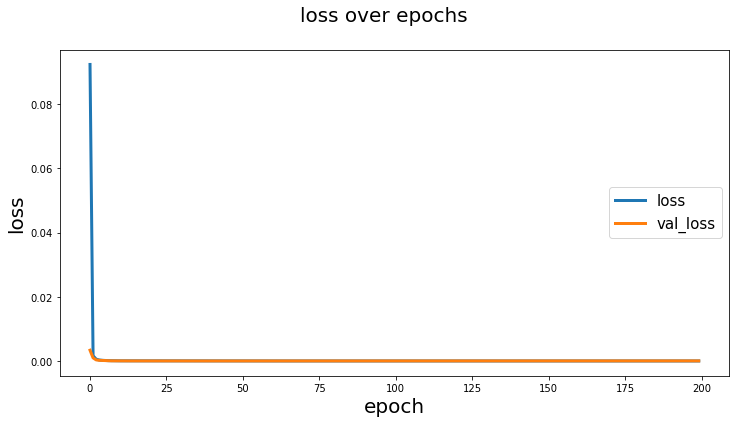

In [24]:
C.Helper.visualize_graph(history)

In [ ]:
y_pred = C.Helper.prediction(test_images_array, model)

In [ ]:
C.Helper.visualize_result(test_images_array, y_test, y_pred)

In [ ]:
C.Helper.evaluate(test_images_array, y_test, model)